# Semantic Segmentation of Water using U-Net
# Part 6 - Improving the Model


In this part I will explore a few ways to increase the model's complexity, allowing for more powerful representations.

In [1]:
import os
import pickle
import time

import numpy as np
import pandas as pd

from unetlib.metrics import BinaryMeanIoU
from unetlib.model import UNet
from unetlib.preprocessing import make_dataframes_for_flow, make_data_generators
import unetlib.visualisation as vs

%matplotlib inline

In [3]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

To make the model more complex and powerful I can take a couple of approaches. On one hand I can increase the initial filters, adding more feature maps (or neurons) to each convolutional layer. I could also increase the number of blocks, adding more layers to create a deeper network. Naturally I could combine the two options to build several permutations of model architectures. However, training and evaluating all would not be an efficient process.

Considering that each layer in the network learns some level of features that help build the next features and so on, it makes sense that more layers allow for a higher level of abstraction of the problem. The more complex the problem, the higher the level of abstraction required.

Regarding the filters, increasing the amount in a layer does not increase the level of abstraction, instead it means there are more feature maps for the next layer to build on. Both the number of layers and the number of filters are important hyperparameters to tune.


## Deep Model
In the first instance, i'm going to focus on increasing the number of layers by adding more blocks to the network. In fact, the architecture described by Ronneberger et al. uses four blocks (four blocks on each side of the U-Net, that is) to perform segmentation of a grayscale image so my decision seems reasonable.

Recall that each encoding block is Conv2D=>Conv2D=>MaxPool and each decoding block is Conv2DTranspose=Concat=>Conv2D=>Conv2D.

### Set Up Model & Training Data

In [2]:
model = UNet(n_filters=32, n_blocks=4, model_name='deep')
model.summary()

Model: "deep_f32_b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [5]:
# Split the test/train data
train_img_df, train_msk_df, test_img_df, test_msk_df, = make_dataframes_for_flow(nwpu_data_dir,
                                                                                 nwpu_mask_dir,
                                                                                 test_split=0.25,
                                                                                 random_state=42
                                                                                )

In [6]:
# Split the training data into train and validation generators
# with augmentation applied to the training data only
aug_dict = {'rotation_range':90,
            'horizontal_flip':True,
            'vertical_flip':True,
            'width_shift_range':0.15,
            'height_shift_range':0.15,
            'zoom_range':0.25
           }

batch_size = 16

train_gen, val_gen, train_fps, val_fps = make_data_generators(train_img_df, train_msk_df,
                                                              nwpu_data_dir, nwpu_mask_dir,
                                                              val_split=0.3,
                                                              batch_size=batch_size,
                                                              aug_dict=aug_dict,
                                                              aug_seed=42)

Found 210 validated image filenames.
Found 210 validated image filenames.
Found 90 validated image filenames.
Found 90 validated image filenames.


In [7]:
# Compile the model
model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=[BinaryMeanIoU(threshold=0.5)]
             )

In [8]:
# Compute steps per epoch
train_steps = int(np.ceil(len(train_fps) / batch_size))
val_steps = int(np.ceil(len(val_fps) / batch_size))

print(f'Train Steps: {train_steps}')
print(f'Val Steps: {val_steps}')

Train Steps: 14
Val Steps: 6


### Train Model

In [9]:
# Number of times to cycle the full training set
epochs = 100

In [ ]:
# Train the model and record the time taken
    
t1 = time.time()
history = model.fit(train_gen, epochs=epochs, steps_per_epoch=train_steps,
                    validation_data=val_gen, validation_steps=val_steps)
runtime = time.time() - t1

# How many minutes did training take?
print(runtime / 60)

In [ ]:
# configure model output directory and filenames
output_dir = 'model_outputs'
os.makedirs(output_dir, exist_ok=True)

hist_filepath = os.path.join(output_dir,
                             f'{model.name}_bs{batch_size}e{epochs}.history.pickle')

weights_filepath = os.path.join(output_dir,
                                f'{model.name}_bs{batch_size}e{epochs}.weights.h5')

In [ ]:
# Save history to pickle
with open(hist_filepath, 'wb') as f:
    pickle.dump(history.history, f)
    
# Save model weights
model.save_weights(weights_filepath)

### Evaluate Model

In [10]:
# Load history if not already available
deep_hist_filepath = 'model_outputs/deep_f32_b4_bs16e100.history.pickle'
with open(deep_hist_filepath, 'rb') as f:
    deep_hist = pickle.load(f)

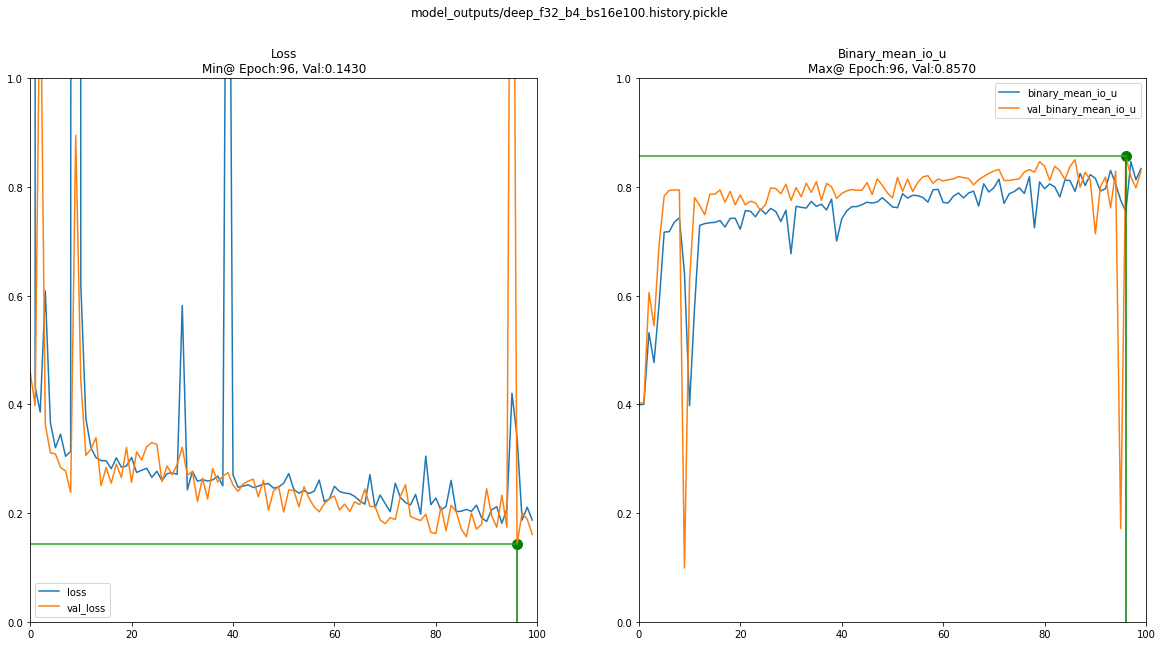

In [11]:
# Create dataframe of history
# deep_hist_df = pd.DataFrame(history.history) # Use this line if model has been trained in this session
deep_hist_df = pd.DataFrame(deep_hist)

# Plot history
vs.plot_model_history(deep_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=deep_hist_filepath);

In [14]:
# Create results dataframe
columns = ['Filepath', 'Filters', 'Blocks', 'Batch Size', 'Epochs', 'Val Loss', 'Val IoU']

deep_results = [os.path.basename(deep_hist_filepath), 32, 4, 16, 100,
                deep_hist_df.val_loss.min(),
                deep_hist_df.at[deep_hist_df.val_loss.argmin(),
                                'val_binary_mean_io_u']
                   ]

results = pd.DataFrame(data=[deep_results], columns=columns)
results

,Filepath,Filters,Blocks,Batch Size,Epochs,Val Loss,Val IoU
0,deep_f32_b4_bs16e100.history.pickle,32,4,16,100,0.143032,0.857046


Here the loss bounces all over the place indicating, most likely, a problem with the learning rate. It could be too high causing it to overshoot the minimum. This can result in training being slow to converge (and not neccessarily to the global minium) or not converging at all. Reducing the learning rate and/or applying momentum could help with this. There are also other optimisers that can be used instead of RMSProp. I explore the ADAM optimiser in Part 7.

## Wide Model
For comparison I also trained a "wide" model. This architecture uses 2 blocks but 64 initial filters.

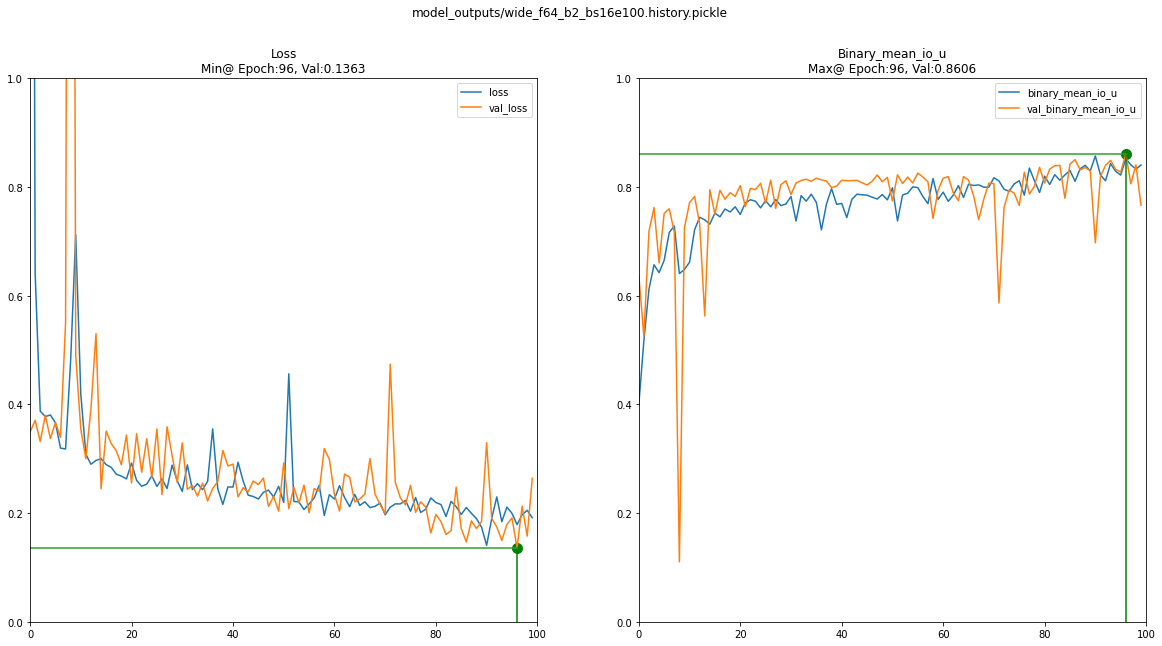

In [12]:
# Wide model
wide_hist_filepath = 'model_outputs/wide_f64_b2_bs16e100.history.pickle'
with open(wide_hist_filepath, 'rb') as f:
    wide_hist = pickle.load(f)

# Create dataframe of history
wide_hist_df = pd.DataFrame(wide_hist)

# Plot history
vs.plot_model_history(wide_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=wide_hist_filepath);

In [15]:
wide_results = [os.path.basename(wide_hist_filepath), 64, 2, 16, 100,
                wide_hist_df.val_loss.min(),
                wide_hist_df.at[wide_hist_df.val_loss.argmin(),
                                'val_binary_mean_io_u']
                   ]

results = results.append({k:v for k,v in zip(columns, wide_results)}, ignore_index=True)
results

,Filepath,Filters,Blocks,Batch Size,Epochs,Val Loss,Val IoU
0,deep_f32_b4_bs16e100.history.pickle,32,4,16,100,0.143032,0.857046
1,wide_f64_b2_bs16e100.history.pickle,64,2,16,100,0.136287,0.860616


In this case, training remains noisey but validation loss and mean IoU have improved slightly. This small difference could just be down to the difference in the random initialisation of the weights. Interestingly, both the deep and wide models reach best validation loss at epoch 96.


## Deep & Wide Model
Finally I trained a deep **and** wide model using the same initial filters and blocks used by Ronneberger et al., 64 and 4 respectively.

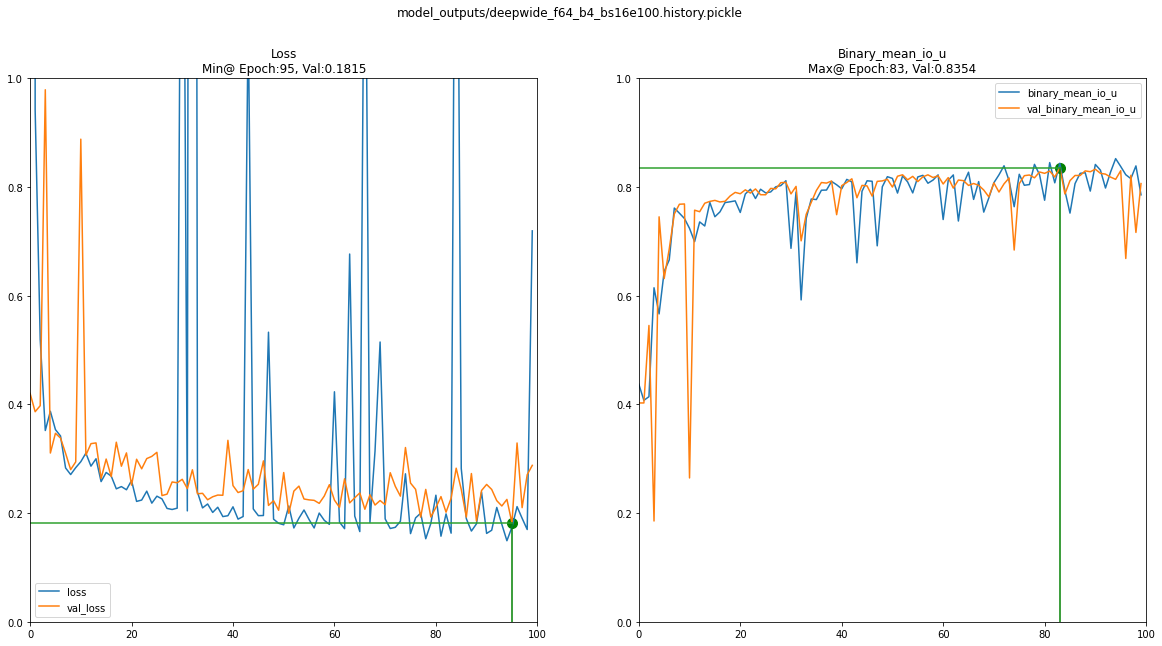

In [13]:
# Deep & Wide
deepwide_hist_filepath = 'model_outputs/deepwide_f64_b4_bs16e100.history.pickle'
with open(deepwide_hist_filepath, 'rb') as f:
    deepwide_hist = pickle.load(f)

# Create dataframe of history
deepwide_hist_df = pd.DataFrame(deepwide_hist)

# Plot history
vs.plot_model_history(deepwide_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=deepwide_hist_filepath);

In [16]:
deepwide_results = [os.path.basename(deepwide_hist_filepath), 64, 2, 16, 100,
                deepwide_hist_df.val_loss.min(),
                deepwide_hist_df.at[deepwide_hist_df.val_loss.argmin(),
                                'val_binary_mean_io_u']
                   ]

results = results.append({k:v for k,v in zip(columns, deepwide_results)}, ignore_index=True)
results

,Filepath,Filters,Blocks,Batch Size,Epochs,Val Loss,Val IoU
0,deep_f32_b4_bs16e100.history.pickle,32,4,16,100,0.143032,0.857046
1,wide_f64_b2_bs16e100.history.pickle,64,2,16,100,0.136287,0.860616
2,deepwide_f64_b4_bs16e100.history.pickle,64,2,16,100,0.181531,0.829805


Here the training loss is very eratic and the model performs the worst out of all 3. The loss seems to plateau quite early on in the process suggesting that a minimum is found quickly but the loss bounces around this minimum. Note that the best Val IoU occured at a different epoch to the best Val Loss. The Val IoU at epoch 95 (best Val Loss) is recorded in the results table above.

Perhaps some other combination of filters and blocks can lead to better performance. However, looking at all of the results it appears that the learning rate requires some attentition before these models can improve.